In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

import dice_ml

import multiprocessing

from collections.abc import Iterable
from functools import partial

from copy import deepcopy

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

### Define research parameters

In [3]:
regression_task = True
continuous_features=['AGE', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6'] # not ['SEX']
metric = 'neg_root_mean_squared_error'
test_size_proportion = 0.2
augment_sample = 0.5

search_pipelines = pipelines.get_regression_pipelines()
search_parameters = models.regression_parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

### Read and preprocess data

In [4]:
df = pd.read_csv(r'../datasets/diabetes.txt', sep='\t')
target = 'Y'

#### split data

In [5]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)

<AxesSubplot:>

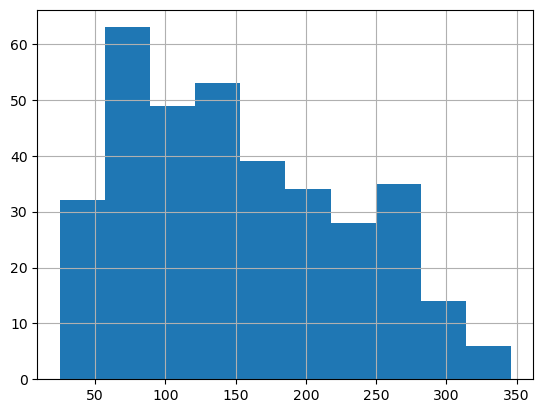

In [6]:
y_train.hist()

In [7]:
full_results_df = pd.DataFrame()

### Whole dataset scores

without augmentation neg_root_mean_squared_error scores:


,lr,ridge,lasso,rf,xgb
w/o aug neg_root_mean_squared_error score,53.853446,53.842869,53.774196,53.762652,53.92463


<AxesSubplot:>

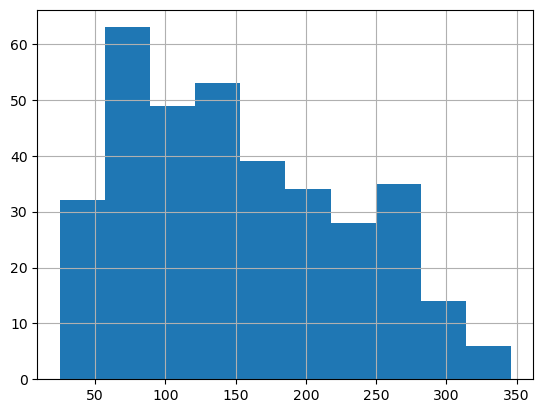

In [8]:
print(f'without augmentation {metric} scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index', columns=[f'w/o aug {metric} score'])
display(whole_dataset_result_df.T)
y_train.hist()

In [9]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [10]:
best_estimators = {}
best_scores = {}
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             kw_args=s.get('kw_args', {})
                             )
    if s['method'][:2] != 'cf':
        X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
        best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
        utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
        result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'],
                                                    orient='index',
                                                    columns=[f'{json.dumps((list(s.values())))} balanced {metric} score'])
        full_results_df = pd.concat([full_results_df, result_df_balanced], axis=1)


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)

    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'],
                                       orient='index',
                                       columns=[f'{json.dumps((list(s.values())))} {metric} score'])
    
    full_results_df = pd.concat([full_results_df, result_df], axis=1)

    print(f'{time.time() - start} seconds for settings {i}')


0 / 11, {'method': 'random'} 23.58705163002014 seconds for settings 0
1 / 11, {'method': 'smote'} 22.77712845802307 seconds for settings 1
2 / 11, {'method': 'cf_random'} 0/176


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


112.18088579177856 seconds for settings 2
3 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}} 0/176


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


251.2268295288086 seconds for settings 3
4 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}} 0/176


100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


206.73079109191895 seconds for settings 4
5 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} 0/176


100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


169.89677906036377 seconds for settings 5
6 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}} 0/176


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


50/176


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


179.89707016944885 seconds for settings 6
7 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}} 0/176


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


50/176


100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


100/176


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


150/176


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


215.45451188087463 seconds for settings 7
8 / 11, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}} 0/176


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


50/176


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


100/176


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


150/176


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


311.65646052360535 seconds for settings 8
9 / 11, {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}} 0/176


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


141.24444675445557 seconds for settings 9
10 / 11, {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}} 0/176


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


50/176


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


100/176


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


150/176


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


151.5258710384369 seconds for settings 10


In [11]:
full_results_df

,w/o aug neg_root_mean_squared_error score,"[""random""] balanced neg_root_mean_squared_error score","[""random""] neg_root_mean_squared_error score","[""smote""] balanced neg_root_mean_squared_error score","[""smote""] neg_root_mean_squared_error score","[""cf_random""] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 0.2, ""diversity_weight"": 5, ""sparsity_weight"": 0.2, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 0.2, ""diversity_weight"": 5, ""sparsity_weight"": 1, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 5, ""diversity_weight"": 0.2, ""sparsity_weight"": 0.2, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 5, ""diversity_weight"": 0.2, ""sparsity_weight"": 1, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 1, ""diversity_weight"": 1, ""sparsity_weight"": 0.2, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_genetic"", {""proximity_weight"": 1, ""diversity_weight"": 1, ""sparsity_weight"": 1, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_kdtree"", {""sparsity_weight"": 0.2, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score","[""cf_kdtree"", {""sparsity_weight"": 1, ""total_CFs"": 1, ""desired_range"": [187.06190176609644, 265.1238035321929]}] neg_root_mean_squared_error score"
lr,53.853446,54.407337,54.329898,54.042278,54.392603,54.093600,55.130788,55.139746,54.755361,55.128056,54.557174,55.123190,54.394327,54.394327
ridge,53.842869,54.398790,54.305594,54.034443,54.388241,54.087923,55.133654,55.139821,54.769815,55.119850,54.603343,55.114478,54.388814,54.388814
lasso,53.774196,54.308541,54.266014,53.948500,54.310061,53.496748,54.883366,54.859844,54.594584,54.773172,54.598373,54.763701,54.289136,54.289136
rf,53.762652,53.811878,52.980496,53.179822,53.873359,53.332526,56.120327,55.362108,55.830231,55.868758,55.849543,56.169173,54.367936,54.367936
xgb,53.924630,54.198043,63.883239,57.079989,56.345535,52.079735,59.401888,62.090150,57.434257,62.411789,61.337266,61.802491,62.735907,62.735907


In [12]:
full_results_df.to_csv(rf'../log/experiment_regression_{metric}_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')

OSError: Cannot save file into a non-existent directory: 'log'